In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)


In [ ]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
import numpy as np
import math
from typing import Tuple

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
import json
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path
pred_threshold       = params.pred_threshold_tick
regular_start        = params.regular_start
regular_start_pred   = params.regular_start_pred
regular_start_shifted= params.regular_start_shifted
regular_end          = params.regular_end
look_back            = params.look_back_tick
trailing_stop_thresh = params.trailing_stop_thresh_tick

n_trials = 100
n_jobs = 1

In [3]:
df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)
df_feat

,open,high,low,close,atr_14,vwap_dev,bb_width_20,ma_5,ma_20,macd_12_26,obv,in_trading,hour,bid,ask,signal_smooth
2014-04-03 10:49:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.131792
2014-04-03 10:50:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.132326
2014-04-03 10:51:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.132862
2014-04-03 10:52:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.133399
2014-04-03 10:53:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.133939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,0.304529,1.249034e+00,0.014819,173.91300,174.838390,-0.422065,3.294477e+08,1,20,173.512900,173.617100,0.001063
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,0.317029,1.246621e+00,0.016242,173.73700,174.736890,-0.466939,3.288235e+08,1,20,173.328000,173.432000,0.005465
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,0.323814,1.245701e+00,0.017430,173.53500,174.634390,-0.502359,3.283690e+08,1,20,173.258000,173.362000,0.007152
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,0.322743,1.245284e+00,0.018221,173.38100,174.527890,-0.526778,3.272742e+08,1,20,173.228000,173.332000,0.007898


{'ATT_DROPOUT': 0.3,
 'ATT_HEADS': 8,
 'CLIPNORM': 1,
 'DROPOUT_LONG': 0.35,
 'DROPOUT_SHORT': 0.25,
 'EARLY_STOP_PATIENCE': 10,
 'ETA_MIN': 2e-05,
 'INITIAL_LR': 0.0007,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 1,
 'MAX_EPOCHS': 60,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 96,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 60,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.0001}


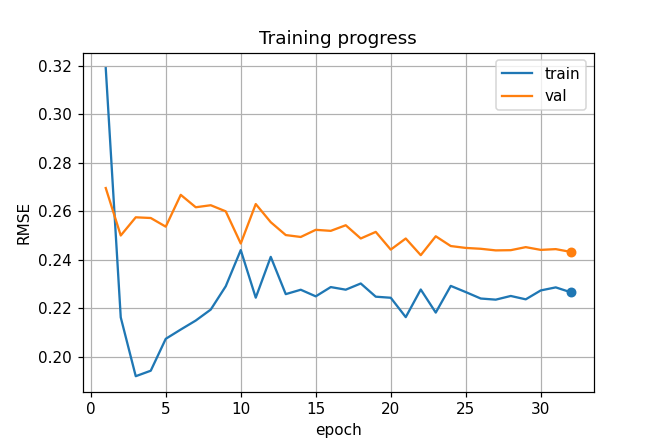

DualMemoryLSTM(
  (short_lstm): LSTM(13, 96, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.2399271376034191, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 128, batch_first=True)
  (do_long): Dropout(p=0.2549328387263775, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(params.model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

model_best


In [5]:
print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df_feat,
    look_back=look_back,
    features_cols=params.features_cols_tick,
    label_col=params.label_col,
    regular_start=regular_start_pred 
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df_feat,
    look_back    = look_back,
    regular_start=regular_start_pred, 
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH']
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df_feat,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1013805, val=211554, te=215642
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.46607
Test zero‐forecast baseline RMSE = 0.51381


std val: 0.30977806
std test: 0.32248157


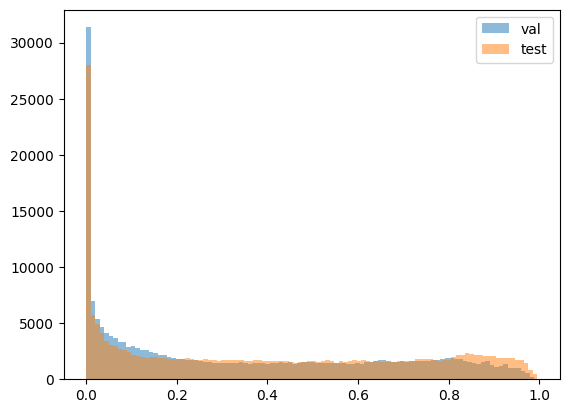

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str
) -> Tuple[float, np.ndarray]:
    """
    Fast per-day RMSE + preds, exactly matching  val‐phase logic:

    • Expects each batch from `loader` to be a tuple of at least
      (xb_batch, yb_batch, day_id_batch, …). We only use the first 3.
    • xb_batch: Tensor(B, W, look_back, F)
    • yb_batch: Tensor(B, W)
    • day_id_batch: Tensor(B,) or (B, W) weekday/day‐id
    """

    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_day_id   = None
    total_sq_err  = 0.0
    total_windows = 0
    all_preds     = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # grab only the first three outputs, ignore raw_close/raw_bid/etc.
            xb_batch, yb_batch, day_id_batch = batch[:3]

            # move to device once
            xb_batch     = xb_batch.to(device, non_blocking=True)
            yb_batch     = yb_batch.to(device, non_blocking=True)
            day_id_batch = day_id_batch.to(device, non_blocking=True)

            # if we got one day_id per window, reduce to one/day
            if day_id_batch.dim() > 1:
                day_id_batch = day_id_batch[:, 0]

            B, W = xb_batch.shape[0], xb_batch.shape[1]

            for i in range(B):
                x_day  = xb_batch[i]             # (W, look_back, F)
                y_day  = yb_batch[i].view(-1)    # (W,)
                day_id = int(day_id_batch[i].item())

                # reset LSTM states exactly as in val loop
                model.reset_short()
                if prev_day_id is not None and day_id < prev_day_id:
                    model.reset_long()
                prev_day_id = day_id

                out      = model(x_day)          # (W, look_back, 1)
                pred_day = out[:, -1, 0]         # (W,)

                total_sq_err  += (pred_day - y_day).pow(2).sum().item()
                total_windows += y_day.numel()
                all_preds.append(pred_day.cpu().numpy())

    rmse  = math.sqrt(total_sq_err / total_windows)
    preds = np.concatenate(all_preds, axis=0)

    print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")
    return rmse, preds


In [9]:
train_rmse, train_preds = evaluate_model(
    model_best, train_loader, device,
    split_name="Train"
)
val_rmse, val_preds     = evaluate_model(
    model_best, val_loader,   device,
    split_name="Validation"
)
test_rmse, test_preds   = evaluate_model(
    model_best, test_loader,  device,
    split_name="Test"
)

print("Train preds:", len(train_preds))
print("Val   preds:", len(val_preds))
print("Test  preds:", len(test_preds))

Train:   0%|          | 0/62 [00:00<?, ?batch/s]


Train RMSE over 1013824 windows = 0.28489


Validation:   0%|          | 0/414 [00:00<?, ?batch/s]


Validation RMSE over 211554 windows = 0.24320


Test:   0%|          | 0/422 [00:00<?, ?batch/s]


Test RMSE over 215642 windows = 0.26929
Train preds: 1013824
Val   preds: 211554
Test  preds: 215642


In [10]:
def add_pred_and_split(
    df: pd.DataFrame,
    train_preds: np.ndarray,
    val_preds: np.ndarray,
    test_preds: np.ndarray,
    day_id_tr: np.ndarray,
    day_id_val: np.ndarray,
    day_id_te: np.ndarray
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Stamp pred_signal for every bar from regular_start_pred onward,
    then simulate actions from regular_start
    """
    # 1) Prepare the output DataFrame
    df_pred = df.copy()
    df_pred["pred_signal"] = np.nan
    df_pred["pred_action"] = 0

    # 2) Map day-id arrays → calendar dates
    all_days = sorted(df_pred.index.normalize().unique())
    tr_days  = [all_days[i] for i in np.unique(day_id_tr).astype(int)]
    val_days = [all_days[i] for i in np.unique(day_id_val).astype(int)]
    te_days  = [all_days[i] for i in np.unique(day_id_te).astype(int)]

    # 3) Generic function to stamp preds on each split
    def stamp_split(days, preds, name):
        mask = (
            df_pred.index.normalize().isin(days)
            & (df_pred.index.time >= regular_start_pred)
        )
        idx = df_pred.loc[mask].index
        if len(idx) != len(preds):
            raise ValueError(
                f"{name}: expected {len(idx)} slots, got {len(preds)} preds"
            )
        df_pred.loc[idx, "pred_signal"] = preds

    # 4) Stamp Train, Val, Test
    stamp_split(tr_days, train_preds, name="Train")
    stamp_split(val_days, val_preds,   name="Val")
    stamp_split(te_days,  test_preds,  name="Test")

    train_val_days = set(tr_days + val_days)
    df_train_val  = df_pred[df_pred.index.normalize().isin(train_val_days)].copy()
    df_test       = df_pred[df_pred.index.normalize().isin(te_days)].copy()

    return df_train_val, train_val_days, df_test, te_days


In [11]:
df_train_val, train_val_days, df_test, te_days = add_pred_and_split(
                                                                    df=df_feat, 
                                                                    train_preds=train_preds,
                                                                    val_preds=val_preds,
                                                                    test_preds=test_preds, 
                                                                    day_id_tr=day_id_tr,
                                                                    day_id_val=day_id_val,
                                                                    day_id_te=day_id_te
                                                                    )

df_train_val

,open,high,low,close,atr_14,vwap_dev,bb_width_20,ma_5,ma_20,macd_12_26,obv,in_trading,hour,bid,ask,signal_smooth,pred_signal,pred_action
2014-04-03 10:49:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,0.000000,28.650,28.65000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.131792,NaN,0
2014-04-03 10:50:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,0.000000,28.650,28.65000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.132326,NaN,0
2014-04-03 10:51:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,0.000000,28.650,28.65000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.132862,NaN,0
2014-04-03 10:52:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,0.000000,28.650,28.65000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.133399,NaN,0
2014-04-03 10:53:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,0.000000,28.650,28.65000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.133939,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-11 20:56:00,140.510,140.62,140.505,140.610,0.105893,1.165021e+00,0.002115,140.546,140.52549,0.040273,3.336946e+08,1,20,140.567800,140.652200,0.000000,0.315324,0
2023-10-11 20:57:00,140.610,140.66,140.530,140.550,0.112493,1.164094e+00,0.001804,140.544,140.53499,0.038238,3.335539e+08,1,20,140.507800,140.592200,0.000000,0.315321,0
2023-10-11 20:58:00,140.550,140.60,140.530,140.585,0.111071,1.164628e+00,0.001544,140.548,140.54474,0.039000,3.336994e+08,1,20,140.542800,140.627200,0.000000,0.314707,0
2023-10-11 20:59:00,140.580,140.62,140.520,140.565,0.112571,1.164309e+00,0.001464,140.564,140.54949,0.037557,3.332814e+08,1,20,140.522800,140.607200,0.000000,0.313636,0


In [12]:
# raw NumPy arrays
signals    = df_train_val["pred_signal"].values.astype(float)
closes     = df_train_val["close"].values.astype(float)
bids       = df_train_val["bid"].values.astype(float)
asks       = df_train_val["ask"].values.astype(float)
timestamps = df_train_val.index.values.astype("datetime64[ns]")

# map each day → positions
day_positions = {
    day: np.flatnonzero(df_train_val.index.normalize().values == day)
    for day in train_val_days
}

# PRE-BUILD each day’s mini-DataFrame once, outside the objective
day_dfs = {
    day: pd.DataFrame({
        "pred_signal": signals[idxs],
        "close"      : closes[idxs]
    }, index=pd.DatetimeIndex(timestamps[idxs]))
    for day, idxs in day_positions.items()
}

# master DataFrame with empty action col
df_master = pd.DataFrame({
    "pred_signal": signals,
    "close"      : closes,
    "bid"        : bids,
    "ask"        : asks,
}, index=pd.DatetimeIndex(timestamps))
df_master["pred_action"] = 0




In [13]:

def objective(trial):
    # —————— 1) Clean slate for this trial ——————
    df_master["pred_action"].values[:] = 0

    # —————— 2) Hyper-parameter suggestions ——————
    pred_threshold     = trial.suggest_float("pred_threshold",     0.03, 0.66)
    trailing_stop_pred = trial.suggest_float("trailing_stop_pred", 0.01, 0.5)

    # —————— 3) Generate actions per day ——————
    print('-----------------------------------')
    print("Generate actions per day...")
    for day, idxs in day_positions.items():
        day_df = day_dfs[day]
        day_act = trades.generate_trade_actions(
            df=day_df,
            col_signal="pred_signal",
            col_action="pred_action",
            buy_threshold=pred_threshold,
            trailing_stop_thresh=trailing_stop_pred,
            regular_start=params.regular_start
        )["pred_action"].fillna(0).astype(np.int8).values
        df_master["pred_action"].values[idxs] = day_act

    # —————— 4) Simulate & score ——————
    print("Simulate and compute average daily P&L...")
    sim_results = trades.simulate_trading(
        results_by_day_sign=df_master,
        col_action="pred_action",
        regular_start=params.regular_start,
        regular_end=params.regular_end,
        ticker=params.ticker
    )

    # — include all actual trading days in the average —
    all_stats  = [stats for _, (_, _, stats) in sim_results.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in sim_results.items():
        del df_sim, trades_list
    del sim_results
    gc.collect()
    
    num_trade_days  = trades.count_trading_days(
        df_master, params.regular_start, params.regular_end
    )

    daily_returns = [s["Strategy Return ($)"] for s in all_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_trade_days if num_trade_days else 0.0

    total_trades  = sum(len(s["Trades Returns ($)"]) for s in all_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    print(f"→ Total return across {num_trade_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)             : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                            : {total_trades}")
    print(f"→ Avg return per trade                    : ${avg_per_trade:.4f}\n")

    return avg_daily_pnl


[I 2025-08-03 18:21:12,108] A new study created in RDB with name: no-name-f235f1fa-1df9-4c28-af2f-e6ac19c9a1da


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $-49.39
→ Avg daily return (all days)             : $-0.0206
→ Total trades                            : 2398
→ Avg return per trade                    : $-0.0206



[I 2025-08-03 18:22:11,037] Trial 0 finished with value: -0.02059466221851543 and parameters: {'pred_threshold': 0.07434370620961735, 'trailing_stop_pred': 0.4068587789525298}. Best is trial 0 with value: -0.02059466221851543.


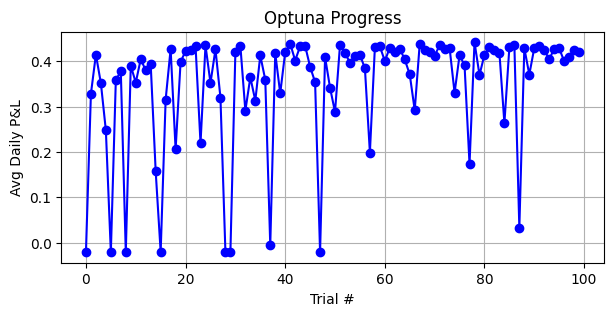

-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $786.72
→ Avg daily return (all days)             : $0.3281
→ Total trades                            : 1893
→ Avg return per trade                    : $0.4156



[I 2025-08-03 18:23:06,330] Trial 1 finished with value: 0.3280746455379483 and parameters: {'pred_threshold': 0.5001584090095922, 'trailing_stop_pred': 0.4933688064748365}. Best is trial 1 with value: 0.3280746455379483.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $993.56
→ Avg daily return (all days)             : $0.4143
→ Total trades                            : 4242
→ Avg return per trade                    : $0.2342



[I 2025-08-03 18:24:01,410] Trial 2 finished with value: 0.41433027522935784 and parameters: {'pred_threshold': 0.3758267167328019, 'trailing_stop_pred': 0.16029360007084065}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $842.41
→ Avg daily return (all days)             : $0.3513
→ Total trades                            : 4861
→ Avg return per trade                    : $0.1733



[I 2025-08-03 18:24:57,276] Trial 3 finished with value: 0.35129649708090077 and parameters: {'pred_threshold': 0.2805198309847775, 'trailing_stop_pred': 0.33646106009969506}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $593.11
→ Avg daily return (all days)             : $0.2473
→ Total trades                            : 1798
→ Avg return per trade                    : $0.3299



[I 2025-08-03 18:25:51,862] Trial 4 finished with value: 0.2473344453711426 and parameters: {'pred_threshold': 0.5773285583009206, 'trailing_stop_pred': 0.13307425067444795}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $-49.62
→ Avg daily return (all days)             : $-0.0207
→ Total trades                            : 2399
→ Avg return per trade                    : $-0.0207



[I 2025-08-03 18:26:49,074] Trial 5 finished with value: -0.020690158465387826 and parameters: {'pred_threshold': 0.14399527803245166, 'trailing_stop_pred': 0.42789129981822965}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $859.21
→ Avg daily return (all days)             : $0.3583
→ Total trades                            : 4649
→ Avg return per trade                    : $0.1848



[I 2025-08-03 18:27:44,852] Trial 6 finished with value: 0.35830316930775646 and parameters: {'pred_threshold': 0.2896647200284458, 'trailing_stop_pred': 0.36244647245461037}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $904.66
→ Avg daily return (all days)             : $0.3773
→ Total trades                            : 5406
→ Avg return per trade                    : $0.1673



[I 2025-08-03 18:28:40,688] Trial 7 finished with value: 0.377256880733945 and parameters: {'pred_threshold': 0.2843612884586145, 'trailing_stop_pred': 0.23970417756294846}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $-49.39
→ Avg daily return (all days)             : $-0.0206
→ Total trades                            : 2398
→ Avg return per trade                    : $-0.0206



[I 2025-08-03 18:29:37,842] Trial 8 finished with value: -0.02059466221851543 and parameters: {'pred_threshold': 0.07990781185015494, 'trailing_stop_pred': 0.17661473976664324}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $934.68
→ Avg daily return (all days)             : $0.3898
→ Total trades                            : 5677
→ Avg return per trade                    : $0.1646



[I 2025-08-03 18:30:33,462] Trial 9 finished with value: 0.38977439532944125 and parameters: {'pred_threshold': 0.2890629094018792, 'trailing_stop_pred': 0.196820711683964}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $845.74
→ Avg daily return (all days)             : $0.3527
→ Total trades                            : 3204
→ Avg return per trade                    : $0.2640



[I 2025-08-03 18:31:27,756] Trial 10 finished with value: 0.3526847372810676 and parameters: {'pred_threshold': 0.4595298655901026, 'trailing_stop_pred': 0.030740760534703232}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $968.93
→ Avg daily return (all days)             : $0.4041
→ Total trades                            : 4054
→ Avg return per trade                    : $0.2390



[I 2025-08-03 18:32:22,210] Trial 11 finished with value: 0.4040558798999166 and parameters: {'pred_threshold': 0.39746434985356416, 'trailing_stop_pred': 0.10600498029943647}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $910.36
→ Avg daily return (all days)             : $0.3796
→ Total trades                            : 3731
→ Avg return per trade                    : $0.2440



[I 2025-08-03 18:33:17,462] Trial 12 finished with value: 0.3796321934945788 and parameters: {'pred_threshold': 0.4265855344377861, 'trailing_stop_pred': 0.06458022294426086}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $942.24
→ Avg daily return (all days)             : $0.3929
→ Total trades                            : 3900
→ Avg return per trade                    : $0.2416



[I 2025-08-03 18:34:11,887] Trial 13 finished with value: 0.3929295246038365 and parameters: {'pred_threshold': 0.4079069091671775, 'trailing_stop_pred': 0.1065959328179911}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $377.26
→ Avg daily return (all days)             : $0.1573
→ Total trades                            : 957
→ Avg return per trade                    : $0.3942



[I 2025-08-03 18:35:06,204] Trial 14 finished with value: 0.15732110091743118 and parameters: {'pred_threshold': 0.651682169349018, 'trailing_stop_pred': 0.2725797521129658}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $-48.44
→ Avg daily return (all days)             : $-0.0202
→ Total trades                            : 2412
→ Avg return per trade                    : $-0.0201



[I 2025-08-03 18:36:04,245] Trial 15 finished with value: -0.020201834862385318 and parameters: {'pred_threshold': 0.18062943579409108, 'trailing_stop_pred': 0.10531943863441097}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $756.00
→ Avg daily return (all days)             : $0.3153
→ Total trades                            : 2260
→ Avg return per trade                    : $0.3345



[I 2025-08-03 18:36:59,272] Trial 16 finished with value: 0.3152643869891576 and parameters: {'pred_threshold': 0.5151505149881658, 'trailing_stop_pred': 0.1743884828441376}. Best is trial 2 with value: 0.41433027522935784.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1022.77
→ Avg daily return (all days)             : $0.4265
→ Total trades                            : 5171
→ Avg return per trade                    : $0.1978



[I 2025-08-03 18:37:54,567] Trial 17 finished with value: 0.4265116763969975 and parameters: {'pred_threshold': 0.3605174503749712, 'trailing_stop_pred': 0.012922996042576365}. Best is trial 17 with value: 0.4265116763969975.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $492.88
→ Avg daily return (all days)             : $0.2055
→ Total trades                            : 3949
→ Avg return per trade                    : $0.1248



[I 2025-08-03 18:38:51,906] Trial 18 finished with value: 0.2055375312760634 and parameters: {'pred_threshold': 0.21899206606345573, 'trailing_stop_pred': 0.018932593554770803}. Best is trial 17 with value: 0.4265116763969975.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $954.63
→ Avg daily return (all days)             : $0.3981
→ Total trades                            : 3940
→ Avg return per trade                    : $0.2423



[I 2025-08-03 18:39:47,855] Trial 19 finished with value: 0.39809591326105087 and parameters: {'pred_threshold': 0.35592030453603607, 'trailing_stop_pred': 0.27596571729000896}. Best is trial 17 with value: 0.4265116763969975.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1012.41
→ Avg daily return (all days)             : $0.4222
→ Total trades                            : 5122
→ Avg return per trade                    : $0.1977



[I 2025-08-03 18:40:43,085] Trial 20 finished with value: 0.42218932443703083 and parameters: {'pred_threshold': 0.3549158716939548, 'trailing_stop_pred': 0.06248383665990825}. Best is trial 17 with value: 0.4265116763969975.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1020.09
→ Avg daily return (all days)             : $0.4254
→ Total trades                            : 5262
→ Avg return per trade                    : $0.1939



[I 2025-08-03 18:41:38,415] Trial 21 finished with value: 0.42539199332777317 and parameters: {'pred_threshold': 0.3515651027225783, 'trailing_stop_pred': 0.0527314410881671}. Best is trial 17 with value: 0.4265116763969975.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1039.61
→ Avg daily return (all days)             : $0.4335
→ Total trades                            : 5678
→ Avg return per trade                    : $0.1831



[I 2025-08-03 18:42:33,799] Trial 22 finished with value: 0.4335308590492077 and parameters: {'pred_threshold': 0.3319164892791999, 'trailing_stop_pred': 0.06041324107957534}. Best is trial 22 with value: 0.4335308590492077.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $525.05
→ Avg daily return (all days)             : $0.2190
→ Total trades                            : 3962
→ Avg return per trade                    : $0.1325



[I 2025-08-03 18:43:30,544] Trial 23 finished with value: 0.21895246038365304 and parameters: {'pred_threshold': 0.22277520765325787, 'trailing_stop_pred': 0.06179176252094665}. Best is trial 22 with value: 0.4335308590492077.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1041.56
→ Avg daily return (all days)             : $0.4343
→ Total trades                            : 6325
→ Avg return per trade                    : $0.1647



[I 2025-08-03 18:44:25,546] Trial 24 finished with value: 0.43434653878231866 and parameters: {'pred_threshold': 0.3132305289550114, 'trailing_stop_pred': 0.01822790994795581}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $843.27
→ Avg daily return (all days)             : $0.3517
→ Total trades                            : 3277
→ Avg return per trade                    : $0.2573



[I 2025-08-03 18:45:20,007] Trial 25 finished with value: 0.3516538782318599 and parameters: {'pred_threshold': 0.4559312710362744, 'trailing_stop_pred': 0.012849301403202208}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1021.28
→ Avg daily return (all days)             : $0.4259
→ Total trades                            : 5766
→ Avg return per trade                    : $0.1771



[I 2025-08-03 18:46:15,258] Trial 26 finished with value: 0.42588782318598833 and parameters: {'pred_threshold': 0.32167881423989386, 'trailing_stop_pred': 0.0945119214145612}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $766.83
→ Avg daily return (all days)             : $0.3198
→ Total trades                            : 7036
→ Avg return per trade                    : $0.1090



[I 2025-08-03 18:47:11,805] Trial 27 finished with value: 0.3197798165137615 and parameters: {'pred_threshold': 0.25171881696522574, 'trailing_stop_pred': 0.015646613041922657}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $-49.65
→ Avg daily return (all days)             : $-0.0207
→ Total trades                            : 2399
→ Avg return per trade                    : $-0.0207



[I 2025-08-03 18:48:09,097] Trial 28 finished with value: -0.02070350291909925 and parameters: {'pred_threshold': 0.1605601499752337, 'trailing_stop_pred': 0.2288086146900526}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $-49.43
→ Avg daily return (all days)             : $-0.0206
→ Total trades                            : 2399
→ Avg return per trade                    : $-0.0206



[I 2025-08-03 18:49:05,552] Trial 29 finished with value: -0.020613844870725605 and parameters: {'pred_threshold': 0.031129104690419573, 'trailing_stop_pred': 0.08090832120123902}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1008.17
→ Avg daily return (all days)             : $0.4204
→ Total trades                            : 5661
→ Avg return per trade                    : $0.1781



[I 2025-08-03 18:50:00,734] Trial 30 finished with value: 0.42042035029190994 and parameters: {'pred_threshold': 0.315599791163054, 'trailing_stop_pred': 0.1350798218584816}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1040.10
→ Avg daily return (all days)             : $0.4337
→ Total trades                            : 5699
→ Avg return per trade                    : $0.1825



[I 2025-08-03 18:50:55,895] Trial 31 finished with value: 0.4337347789824854 and parameters: {'pred_threshold': 0.3343258780179262, 'trailing_stop_pred': 0.043188624096450606}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $697.30
→ Avg daily return (all days)             : $0.2908
→ Total trades                            : 5126
→ Avg return per trade                    : $0.1360



[I 2025-08-03 18:51:52,306] Trial 32 finished with value: 0.29078440366972474 and parameters: {'pred_threshold': 0.24173700547340612, 'trailing_stop_pred': 0.0445193060451011}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $873.30
→ Avg daily return (all days)             : $0.3642
→ Total trades                            : 3179
→ Avg return per trade                    : $0.2747



[I 2025-08-03 18:52:46,758] Trial 33 finished with value: 0.3641776480400334 and parameters: {'pred_threshold': 0.4453516670906191, 'trailing_stop_pred': 0.13689755842754125}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $750.48
→ Avg daily return (all days)             : $0.3130
→ Total trades                            : 2647
→ Avg return per trade                    : $0.2835



[I 2025-08-03 18:53:41,009] Trial 34 finished with value: 0.31295954962468725 and parameters: {'pred_threshold': 0.5040873467614583, 'trailing_stop_pred': 0.03693404571555098}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $988.92
→ Avg daily return (all days)             : $0.4124
→ Total trades                            : 4450
→ Avg return per trade                    : $0.2222



[I 2025-08-03 18:54:35,782] Trial 35 finished with value: 0.4123949124270225 and parameters: {'pred_threshold': 0.381999122592915, 'trailing_stop_pred': 0.08975359770848967}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $860.26
→ Avg daily return (all days)             : $0.3587
→ Total trades                            : 3777
→ Avg return per trade                    : $0.2278



[I 2025-08-03 18:55:31,492] Trial 36 finished with value: 0.3587402001668057 and parameters: {'pred_threshold': 0.3197498631088593, 'trailing_stop_pred': 0.48063373426847067}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $-12.42
→ Avg daily return (all days)             : $-0.0052
→ Total trades                            : 2553
→ Avg return per trade                    : $-0.0049



[I 2025-08-03 18:56:28,589] Trial 37 finished with value: -0.005179733110925773 and parameters: {'pred_threshold': 0.19297121141673276, 'trailing_stop_pred': 0.3188562496064037}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1001.11
→ Avg daily return (all days)             : $0.4175
→ Total trades                            : 4731
→ Avg return per trade                    : $0.2116



[I 2025-08-03 18:57:23,646] Trial 38 finished with value: 0.4174770642201835 and parameters: {'pred_threshold': 0.3712403098941538, 'trailing_stop_pred': 0.07799900750747685}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $788.63
→ Avg daily return (all days)             : $0.3289
→ Total trades                            : 7126
→ Avg return per trade                    : $0.1107



[I 2025-08-03 18:58:19,725] Trial 39 finished with value: 0.32887114261884903 and parameters: {'pred_threshold': 0.25368951520835714, 'trailing_stop_pred': 0.040167301309172815}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1006.59
→ Avg daily return (all days)             : $0.4198
→ Total trades                            : 5774
→ Avg return per trade                    : $0.1743



[I 2025-08-03 18:59:14,943] Trial 40 finished with value: 0.41976355296080065 and parameters: {'pred_threshold': 0.31045459420476235, 'trailing_stop_pred': 0.1300685864880906}. Best is trial 24 with value: 0.43434653878231866.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1051.49
→ Avg daily return (all days)             : $0.4385
→ Total trades                            : 5950
→ Avg return per trade                    : $0.1767



[I 2025-08-03 19:00:09,844] Trial 41 finished with value: 0.43848498748957465 and parameters: {'pred_threshold': 0.3274394814612755, 'trailing_stop_pred': 0.012119049327928599}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $962.08
→ Avg daily return (all days)             : $0.4012
→ Total trades                            : 7170
→ Avg return per trade                    : $0.1342



[I 2025-08-03 19:01:05,376] Trial 42 finished with value: 0.4012001668056714 and parameters: {'pred_threshold': 0.27230038877311596, 'trailing_stop_pred': 0.015360915791863957}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1037.44
→ Avg daily return (all days)             : $0.4326
→ Total trades                            : 5651
→ Avg return per trade                    : $0.1836



[I 2025-08-03 19:02:00,442] Trial 43 finished with value: 0.4326292743953294 and parameters: {'pred_threshold': 0.33549476550605223, 'trailing_stop_pred': 0.043698360241632414}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1039.95
→ Avg daily return (all days)             : $0.4337
→ Total trades                            : 5701
→ Avg return per trade                    : $0.1824



[I 2025-08-03 19:02:55,378] Trial 44 finished with value: 0.433673894912427 and parameters: {'pred_threshold': 0.33394449415405864, 'trailing_stop_pred': 0.04608836717660436}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $928.77
→ Avg daily return (all days)             : $0.3873
→ Total trades                            : 3874
→ Avg return per trade                    : $0.2397



[I 2025-08-03 19:03:50,053] Trial 45 finished with value: 0.38731150959132604 and parameters: {'pred_threshold': 0.4146595507855476, 'trailing_stop_pred': 0.07771724605623159}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $848.22
→ Avg daily return (all days)             : $0.3537
→ Total trades                            : 4436
→ Avg return per trade                    : $0.1912



[I 2025-08-03 19:04:46,267] Trial 46 finished with value: 0.35371768140116766 and parameters: {'pred_threshold': 0.2939103195391184, 'trailing_stop_pred': 0.3964678961571487}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $-49.43
→ Avg daily return (all days)             : $-0.0206
→ Total trades                            : 2399
→ Avg return per trade                    : $-0.0206



[I 2025-08-03 19:05:43,068] Trial 47 finished with value: -0.02061342785654712 and parameters: {'pred_threshold': 0.12590986054841993, 'trailing_stop_pred': 0.11685964315548023}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $980.28
→ Avg daily return (all days)             : $0.4088
→ Total trades                            : 4385
→ Avg return per trade                    : $0.2236



[I 2025-08-03 19:06:37,784] Trial 48 finished with value: 0.40878940783986656 and parameters: {'pred_threshold': 0.39144655843059634, 'trailing_stop_pred': 0.05916662245421271}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $818.63
→ Avg daily return (all days)             : $0.3414
→ Total trades                            : 2633
→ Avg return per trade                    : $0.3109



[I 2025-08-03 19:07:32,523] Trial 49 finished with value: 0.3413790658882402 and parameters: {'pred_threshold': 0.48027492532335647, 'trailing_stop_pred': 0.16127397121784284}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $690.48
→ Avg daily return (all days)             : $0.2879
→ Total trades                            : 2313
→ Avg return per trade                    : $0.2985



[I 2025-08-03 19:08:26,777] Trial 50 finished with value: 0.2879399499582986 and parameters: {'pred_threshold': 0.5354954944258653, 'trailing_stop_pred': 0.07622069558881905}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1043.60
→ Avg daily return (all days)             : $0.4352
→ Total trades                            : 6033
→ Avg return per trade                    : $0.1730



[I 2025-08-03 19:09:22,045] Trial 51 finished with value: 0.4351939115929942 and parameters: {'pred_threshold': 0.32212897051407746, 'trailing_stop_pred': 0.03310203649865656}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1002.78
→ Avg daily return (all days)             : $0.4182
→ Total trades                            : 6792
→ Avg return per trade                    : $0.1476



[I 2025-08-03 19:10:17,869] Trial 52 finished with value: 0.41817264386989156 and parameters: {'pred_threshold': 0.29350592384195273, 'trailing_stop_pred': 0.039781017062412584}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $949.90
→ Avg daily return (all days)             : $0.3961
→ Total trades                            : 7146
→ Avg return per trade                    : $0.1329



[I 2025-08-03 19:11:13,706] Trial 53 finished with value: 0.3961213511259383 and parameters: {'pred_threshold': 0.2713486531113328, 'trailing_stop_pred': 0.02741929931433639}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $985.15
→ Avg daily return (all days)             : $0.4108
→ Total trades                            : 4676
→ Avg return per trade                    : $0.2107



[I 2025-08-03 19:12:08,755] Trial 54 finished with value: 0.4108215179316097 and parameters: {'pred_threshold': 0.33910557385441403, 'trailing_stop_pred': 0.19890574948900558}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $992.48
→ Avg daily return (all days)             : $0.4139
→ Total trades                            : 4641
→ Avg return per trade                    : $0.2139



[I 2025-08-03 19:13:03,839] Trial 55 finished with value: 0.4138786488740618 and parameters: {'pred_threshold': 0.38211201147343854, 'trailing_stop_pred': 0.029812389163688082}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $920.60
→ Avg daily return (all days)             : $0.3839
→ Total trades                            : 3863
→ Avg return per trade                    : $0.2383



[I 2025-08-03 19:13:58,454] Trial 56 finished with value: 0.3839028356964137 and parameters: {'pred_threshold': 0.4186897472437641, 'trailing_stop_pred': 0.06533876096389804}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $476.29
→ Avg daily return (all days)             : $0.1986
→ Total trades                            : 3874
→ Avg return per trade                    : $0.1229



[I 2025-08-03 19:14:54,942] Trial 57 finished with value: 0.19862010008340286 and parameters: {'pred_threshold': 0.21963042951138168, 'trailing_stop_pred': 0.1028248403668625}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1030.94
→ Avg daily return (all days)             : $0.4299
→ Total trades                            : 5627
→ Avg return per trade                    : $0.1832



[I 2025-08-03 19:15:50,567] Trial 58 finished with value: 0.42991743119266057 and parameters: {'pred_threshold': 0.3356030210005101, 'trailing_stop_pred': 0.05311682716095331}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1037.05
→ Avg daily return (all days)             : $0.4325
→ Total trades                            : 6617
→ Avg return per trade                    : $0.1567



[I 2025-08-03 19:16:45,658] Trial 59 finished with value: 0.43246413678065054 and parameters: {'pred_threshold': 0.30459800747882415, 'trailing_stop_pred': 0.011049774051292607}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $958.88
→ Avg daily return (all days)             : $0.3999
→ Total trades                            : 7110
→ Avg return per trade                    : $0.1349



[I 2025-08-03 19:17:41,554] Trial 60 finished with value: 0.3998682235195997 and parameters: {'pred_threshold': 0.2724060125446364, 'trailing_stop_pred': 0.03311773121335432}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1030.51
→ Avg daily return (all days)             : $0.4297
→ Total trades                            : 5608
→ Avg return per trade                    : $0.1838



[I 2025-08-03 19:18:36,651] Trial 61 finished with value: 0.4297368640533778 and parameters: {'pred_threshold': 0.3366549730312476, 'trailing_stop_pred': 0.05047920062753851}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1009.05
→ Avg daily return (all days)             : $0.4208
→ Total trades                            : 4959
→ Avg return per trade                    : $0.2035



[I 2025-08-03 19:19:31,794] Trial 62 finished with value: 0.4207889908256881 and parameters: {'pred_threshold': 0.36406544612157016, 'trailing_stop_pred': 0.06494793059644406}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1024.48
→ Avg daily return (all days)             : $0.4272
→ Total trades                            : 5489
→ Avg return per trade                    : $0.1866



[I 2025-08-03 19:20:27,155] Trial 63 finished with value: 0.42722351959966637 and parameters: {'pred_threshold': 0.33437166732788237, 'trailing_stop_pred': 0.08964341186340237}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $967.66
→ Avg daily return (all days)             : $0.4035
→ Total trades                            : 4310
→ Avg return per trade                    : $0.2245



[I 2025-08-03 19:21:22,243] Trial 64 finished with value: 0.4035283569641368 and parameters: {'pred_threshold': 0.3992541269746993, 'trailing_stop_pred': 0.025486610757903257}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $888.60
→ Avg daily return (all days)             : $0.3706
→ Total trades                            : 3328
→ Avg return per trade                    : $0.2670



[I 2025-08-03 19:22:16,974] Trial 65 finished with value: 0.3705604670558799 and parameters: {'pred_threshold': 0.4379318207821246, 'trailing_stop_pred': 0.11616296693720668}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $699.92
→ Avg daily return (all days)             : $0.2919
→ Total trades                            : 5381
→ Avg return per trade                    : $0.1301



[I 2025-08-03 19:23:13,395] Trial 66 finished with value: 0.29187656380316934 and parameters: {'pred_threshold': 0.24302689113455314, 'trailing_stop_pred': 0.04752861670365606}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1049.43
→ Avg daily return (all days)             : $0.4376
→ Total trades                            : 6156
→ Avg return per trade                    : $0.1705



[I 2025-08-03 19:24:08,870] Trial 67 finished with value: 0.4376251042535447 and parameters: {'pred_threshold': 0.3178679120153205, 'trailing_stop_pred': 0.024408331470575216}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1018.51
→ Avg daily return (all days)             : $0.4247
→ Total trades                            : 6654
→ Avg return per trade                    : $0.1531



[I 2025-08-03 19:25:05,414] Trial 68 finished with value: 0.42473436196830694 and parameters: {'pred_threshold': 0.29992357950640813, 'trailing_stop_pred': 0.030749078442281613}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1006.03
→ Avg daily return (all days)             : $0.4195
→ Total trades                            : 4915
→ Avg return per trade                    : $0.2047



[I 2025-08-03 19:26:01,530] Trial 69 finished with value: 0.4195296080066722 and parameters: {'pred_threshold': 0.3654371295469819, 'trailing_stop_pred': 0.07061647372162766}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $988.48
→ Avg daily return (all days)             : $0.4122
→ Total trades                            : 7023
→ Avg return per trade                    : $0.1407



[I 2025-08-03 19:26:57,219] Trial 70 finished with value: 0.412208507089241 and parameters: {'pred_threshold': 0.28130308300503054, 'trailing_stop_pred': 0.012978461269343596}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1041.36
→ Avg daily return (all days)             : $0.4343
→ Total trades                            : 5861
→ Avg return per trade                    : $0.1777



[I 2025-08-03 19:27:52,547] Trial 71 finished with value: 0.4342631359466222 and parameters: {'pred_threshold': 0.3269675633633216, 'trailing_stop_pred': 0.0454295948490555}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1021.40
→ Avg daily return (all days)             : $0.4259
→ Total trades                            : 5873
→ Avg return per trade                    : $0.1739



[I 2025-08-03 19:28:47,756] Trial 72 finished with value: 0.42594036697247706 and parameters: {'pred_threshold': 0.3173735401995432, 'trailing_stop_pred': 0.09020307655650818}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1028.51
→ Avg daily return (all days)             : $0.4289
→ Total trades                            : 5316
→ Avg return per trade                    : $0.1935



[I 2025-08-03 19:29:42,797] Trial 73 finished with value: 0.4289040867389491 and parameters: {'pred_threshold': 0.3519552931148379, 'trailing_stop_pred': 0.025025260281356702}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $791.60
→ Avg daily return (all days)             : $0.3301
→ Total trades                            : 7049
→ Avg return per trade                    : $0.1123



[I 2025-08-03 19:30:39,149] Trial 74 finished with value: 0.3301084236864053 and parameters: {'pred_threshold': 0.2541853076992907, 'trailing_stop_pred': 0.0583179255510411}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $990.11
→ Avg daily return (all days)             : $0.4129
→ Total trades                            : 4593
→ Avg return per trade                    : $0.2156



[I 2025-08-03 19:31:33,931] Trial 75 finished with value: 0.41288865721434526 and parameters: {'pred_threshold': 0.38291338607773523, 'trailing_stop_pred': 0.04266764047219408}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $936.94
→ Avg daily return (all days)             : $0.3907
→ Total trades                            : 4487
→ Avg return per trade                    : $0.2088



[I 2025-08-03 19:32:30,196] Trial 76 finished with value: 0.3907164303586322 and parameters: {'pred_threshold': 0.3131203165431535, 'trailing_stop_pred': 0.31787815787616835}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $414.96
→ Avg daily return (all days)             : $0.1730
→ Total trades                            : 1470
→ Avg return per trade                    : $0.2823



[I 2025-08-03 19:33:24,869] Trial 77 finished with value: 0.17304336947456211 and parameters: {'pred_threshold': 0.6244423577053155, 'trailing_stop_pred': 0.0217137087260122}. Best is trial 41 with value: 0.43848498748957465.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1058.63
→ Avg daily return (all days)             : $0.4415
→ Total trades                            : 5837
→ Avg return per trade                    : $0.1814



[I 2025-08-03 19:34:20,155] Trial 78 finished with value: 0.4414645537948291 and parameters: {'pred_threshold': 0.32998063577475023, 'trailing_stop_pred': 0.01040600840550464}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $885.24
→ Avg daily return (all days)             : $0.3692
→ Total trades                            : 7386
→ Avg return per trade                    : $0.1199



[I 2025-08-03 19:35:16,503] Trial 79 finished with value: 0.3691588824020016 and parameters: {'pred_threshold': 0.2626664693168946, 'trailing_stop_pred': 0.03742680811596849}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $992.95
→ Avg daily return (all days)             : $0.4141
→ Total trades                            : 7007
→ Avg return per trade                    : $0.1417



[I 2025-08-03 19:36:12,389] Trial 80 finished with value: 0.4140721434528774 and parameters: {'pred_threshold': 0.28779967062421746, 'trailing_stop_pred': 0.011082897307016153}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1035.10
→ Avg daily return (all days)             : $0.4316
→ Total trades                            : 5871
→ Avg return per trade                    : $0.1763



[I 2025-08-03 19:37:07,679] Trial 81 finished with value: 0.4316492910758966 and parameters: {'pred_threshold': 0.32437331348052423, 'trailing_stop_pred': 0.05806218542710699}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1017.02
→ Avg daily return (all days)             : $0.4241
→ Total trades                            : 5197
→ Avg return per trade                    : $0.1957



[I 2025-08-03 19:38:02,915] Trial 82 finished with value: 0.4241105087572978 and parameters: {'pred_threshold': 0.3487552319159353, 'trailing_stop_pred': 0.07699761718363216}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1003.09
→ Avg daily return (all days)             : $0.4183
→ Total trades                            : 4791
→ Avg return per trade                    : $0.2094



[I 2025-08-03 19:38:58,192] Trial 83 finished with value: 0.4183023352793995 and parameters: {'pred_threshold': 0.373490331440569, 'trailing_stop_pred': 0.05021083430480369}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $631.17
→ Avg daily return (all days)             : $0.2632
→ Total trades                            : 4260
→ Avg return per trade                    : $0.1482



[I 2025-08-03 19:39:55,176] Trial 84 finished with value: 0.2632055879899916 and parameters: {'pred_threshold': 0.2321870714333566, 'trailing_stop_pred': 0.028559090092374846}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1032.21
→ Avg daily return (all days)             : $0.4304
→ Total trades                            : 6598
→ Avg return per trade                    : $0.1564



[I 2025-08-03 19:40:50,660] Trial 85 finished with value: 0.43044703919933275 and parameters: {'pred_threshold': 0.3041980624518078, 'trailing_stop_pred': 0.022695872809067364}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1045.73
→ Avg daily return (all days)             : $0.4361
→ Total trades                            : 5949
→ Avg return per trade                    : $0.1758



[I 2025-08-03 19:41:46,248] Trial 86 finished with value: 0.4360842368640534 and parameters: {'pred_threshold': 0.3242173365765442, 'trailing_stop_pred': 0.03711877066307627}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $79.13
→ Avg daily return (all days)             : $0.0330
→ Total trades                            : 2879
→ Avg return per trade                    : $0.0275



[I 2025-08-03 19:42:43,156] Trial 87 finished with value: 0.0329974979149291 and parameters: {'pred_threshold': 0.19733334256046683, 'trailing_stop_pred': 0.04040277507056898}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1027.61
→ Avg daily return (all days)             : $0.4285
→ Total trades                            : 5451
→ Avg return per trade                    : $0.1885



[I 2025-08-03 19:43:38,947] Trial 88 finished with value: 0.4285271059216014 and parameters: {'pred_threshold': 0.34739884088911516, 'trailing_stop_pred': 0.010376624778885709}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $888.09
→ Avg daily return (all days)             : $0.3703
→ Total trades                            : 2807
→ Avg return per trade                    : $0.3164



[I 2025-08-03 19:44:34,874] Trial 89 finished with value: 0.37034695579649707 and parameters: {'pred_threshold': 0.4041943852569191, 'trailing_stop_pred': 0.46949063051555207}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1028.27
→ Avg daily return (all days)             : $0.4288
→ Total trades                            : 5881
→ Avg return per trade                    : $0.1748



[I 2025-08-03 19:45:30,845] Trial 90 finished with value: 0.42880233527939954 and parameters: {'pred_threshold': 0.3221588935385417, 'trailing_stop_pred': 0.0701436396850595}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1038.05
→ Avg daily return (all days)             : $0.4329
→ Total trades                            : 5802
→ Avg return per trade                    : $0.1789



[I 2025-08-03 19:46:26,425] Trial 91 finished with value: 0.43288031693077567 and parameters: {'pred_threshold': 0.3285279504987995, 'trailing_stop_pred': 0.052074592445289336}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1018.48
→ Avg daily return (all days)             : $0.4247
→ Total trades                            : 5168
→ Avg return per trade                    : $0.1971



[I 2025-08-03 19:47:22,295] Trial 92 finished with value: 0.424721434528774 and parameters: {'pred_threshold': 0.35873644752754413, 'trailing_stop_pred': 0.0339803511520105}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $968.34
→ Avg daily return (all days)             : $0.4038
→ Total trades                            : 6596
→ Avg return per trade                    : $0.1468



[I 2025-08-03 19:48:17,917] Trial 93 finished with value: 0.40381150959132606 and parameters: {'pred_threshold': 0.28740143052178363, 'trailing_stop_pred': 0.0875531132526931}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1024.24
→ Avg daily return (all days)             : $0.4271
→ Total trades                            : 5456
→ Avg return per trade                    : $0.1877



[I 2025-08-03 19:49:12,823] Trial 94 finished with value: 0.42712385321100915 and parameters: {'pred_threshold': 0.3463823697787668, 'trailing_stop_pred': 0.02262824817130122}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1025.73
→ Avg daily return (all days)             : $0.4277
→ Total trades                            : 6459
→ Avg return per trade                    : $0.1588



[I 2025-08-03 19:50:08,034] Trial 95 finished with value: 0.42774228523769814 and parameters: {'pred_threshold': 0.3061913029259127, 'trailing_stop_pred': 0.042608909035520205}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $958.94
→ Avg daily return (all days)             : $0.3999
→ Total trades                            : 6892
→ Avg return per trade                    : $0.1391



[I 2025-08-03 19:51:03,725] Trial 96 finished with value: 0.3998894912427023 and parameters: {'pred_threshold': 0.27497941898031225, 'trailing_stop_pred': 0.0643533325993319}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $982.05
→ Avg daily return (all days)             : $0.4095
→ Total trades                            : 4369
→ Avg return per trade                    : $0.2248



[I 2025-08-03 19:51:58,903] Trial 97 finished with value: 0.40953085904920766 and parameters: {'pred_threshold': 0.38433141664271947, 'trailing_stop_pred': 0.0965770827892117}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1017.75
→ Avg daily return (all days)             : $0.4244
→ Total trades                            : 5021
→ Avg return per trade                    : $0.2027



[I 2025-08-03 19:52:53,644] Trial 98 finished with value: 0.4244182652210175 and parameters: {'pred_threshold': 0.3669854609437712, 'trailing_stop_pred': 0.021646572279287384}. Best is trial 78 with value: 0.4414645537948291.


-----------------------------------
Generate actions per day...
Simulate and compute average daily P&L...
→ Total return across 2398 trading days: $1005.05
→ Avg daily return (all days)             : $0.4191
→ Total trades                            : 6683
→ Avg return per trade                    : $0.1504



[I 2025-08-03 19:53:49,117] Trial 99 finished with value: 0.4191184320266889 and parameters: {'pred_threshold': 0.2951649641033137, 'trailing_stop_pred': 0.054847830309373236}. Best is trial 78 with value: 0.4414645537948291.
/tmp/ipykernel_80340/2402008646.py:24: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


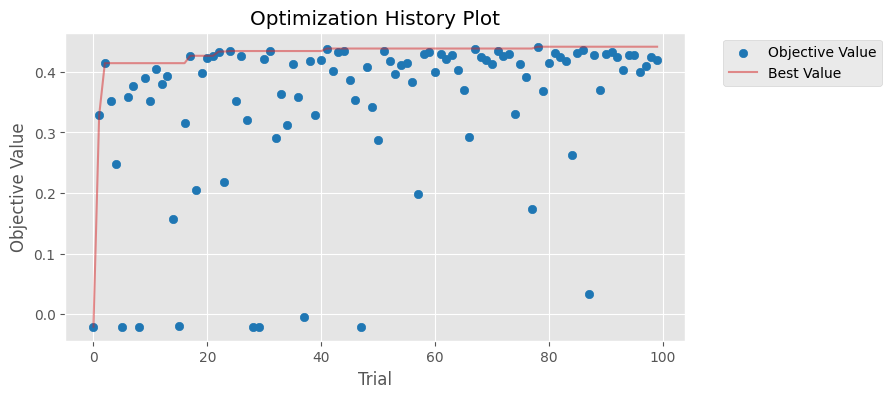

Best Parameters       : {'pred_threshold': 0.32998063577475023, 'trailing_stop_pred': 0.01040600840550464}
Best Average Daily P&L: 0.4414645537948291

Hyperparameter importances (higher ⇒ more impact):
  pred_threshold      : 0.997
  trailing_stop_pred  : 0.003


NameError: name 'os' is not defined

In [14]:
# rest of your Optuna setup & study.optimize() 
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)
storage = RDBStorage(
    url="sqlite:///optuna_study.db",
    engine_kwargs={"connect_args": {"timeout": 20, "check_same_thread": False}}
)
study = optuna.create_study(
    storage        = storage,
    load_if_exists = True,
    direction      = "maximize",
    pruner         = pruner,
)
study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.cleanup_callback, plots.lightweight_plot_callback],
    gc_after_trial    = True,
    show_progress_bar = False,
    catch             = (MemoryError,),
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

/tmp/ipykernel_80340/3968624097.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


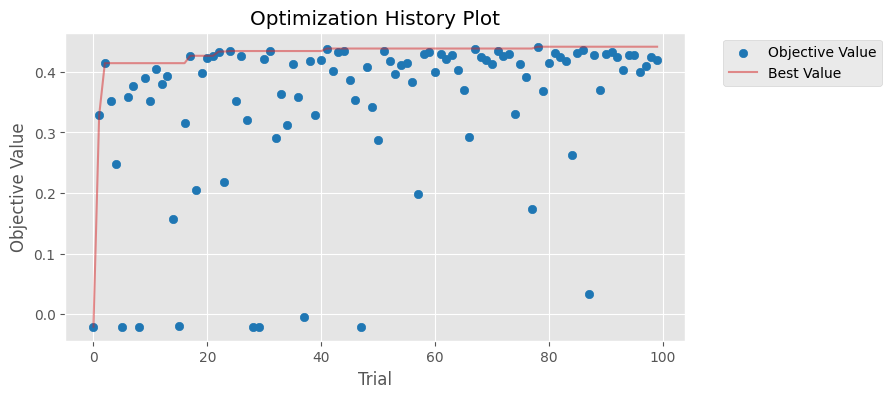

Best Parameters       : {'pred_threshold': 0.32998063577475023, 'trailing_stop_pred': 0.01040600840550464}
Best Average Daily P&L: 0.4414645537948291

Hyperparameter importances (higher ⇒ more impact):
  pred_threshold      : 0.995
  trailing_stop_pred  : 0.005

Optuna results (and importances) saved to: optuna_results/GOOGL_20140403-20231011_optuna_predsig_pars.json


In [17]:
# Final plots & JSON dump (unchanged)...
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df_train_val.index.normalize().min().strftime("%Y%m%d")
last_day  = df_train_val.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{first_day}-{last_day}_optuna_predsig_pars_{study.best_value}_{params.model_path}.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")

In [ ]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

print(stats)

In [ ]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal'], color='C0', alpha=0.5, bins=50, label='true signal')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

In [ ]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred_signal vs. signal')
plt.axis('equal')
plt.show()

In [ ]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the smoothed signal on a given day.

# pick a single day or time span
day = df_test.index.normalize().unique()[-1]
mask = df_test.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'signal'], label='signal')
plt.plot(df_test.index[mask], df_test.loc[mask,'pred_signal'],   label='pred_signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_train_val,              # DF with pred_action
    col_action          = "pred_action",              # name of the discrete action column
    regular_start       = params.regular_start,   
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


In [ ]:
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_test

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "signal",
            col_signal2       = "pred_signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == date_to_test]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_test)
